<a href="https://colab.research.google.com/github/AnuraagVasal/Avasal_64061/blob/main/Assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download dogs-vs-cats

 99% 800M/812M [00:04<00:00, 199MB/s]
100% 812M/812M [00:04<00:00, 178MB/s]


In [8]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip

**QUESTION 1**
Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation 
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce 
overfitting and improve performance in developing a network that you train from scratch. What 
performance did you achieve?  

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
shutil.rmtree("./cats_vs_dogs_small",ignore_errors=True)
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Building the model

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [14]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [15]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [16]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
      break

(32, 16)
(32, 16)
(32, 16)


In [17]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [18]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Instantiating a small convnet for dogs vs. cats classification

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

We made a model having 5 conv2D layers and 4 maxpooling layers.

Configuring the model for training

In [21]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Data preprocessing

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 221s 3s/step - loss: 0.7099 - accuracy: 0.5055 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 209s 3s/step - loss: 0.6927 - accuracy: 0.5500 - val_loss: 0.6607 - val_accuracy: 0.6380
Epoch 3/10
63/63 [==============================] - 216s 3s/step - loss: 0.6639 - accuracy: 0.6120 - val_loss: 0.6905 - val_accuracy: 0.6070
Epoch 4/10
63/63 [==============================] - 216s 3s/step - loss: 0.6469 - accuracy: 0.6495 - val_loss: 0.6080 - val_accuracy: 0.6610
Epoch 5/10
63/63 [==============================] - 221s 4s/step - loss: 0.6076 - accuracy: 0.6905 - val_loss: 0.6067 - val_accuracy: 0.6670
Epoch 6/10
63/63 [==============================] - 218s 3s/step - loss: 0.5624 - accuracy: 0.7210 - val_loss: 0.5867 - val_accuracy: 0.6890
Epoch 7/10
63/63 [==============================] - 208s 3s/step - loss: 0.5349 - accuracy: 0.7415 - val_loss: 0.5506 - val_accuracy: 0.7360
Epoch 8/10
63

Displaying curves of loss and accuracy during training

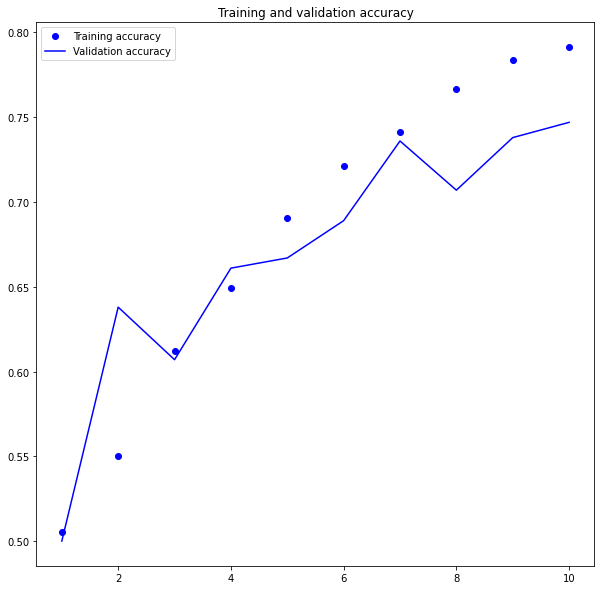

<Figure size 432x288 with 0 Axes>

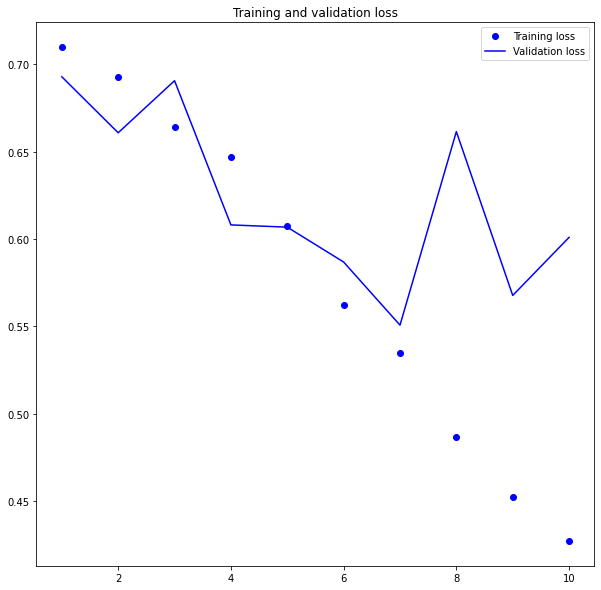

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set

In [24]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 24s 743ms/step - loss: 0.5779 - accuracy: 0.7030
Test accuracy: 0.703


The performance that I achieved with a training sample of 1,000 and a validation sample of 500 and a test sample of 500 was 70% for test accuracy.

**QUESTION #2**

In [25]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images

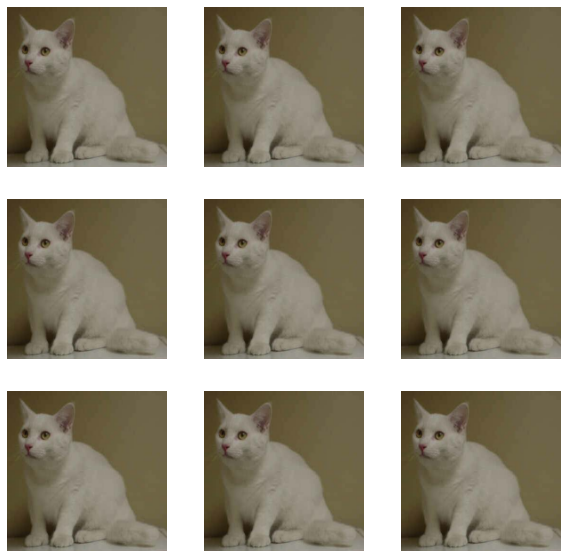

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Defining a new convnet that includes image augmentation and dropout

In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 221s 3s/step - loss: 0.7086 - accuracy: 0.5000 - val_loss: 1.2199 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 225s 4s/step - loss: 0.6988 - accuracy: 0.5370 - val_loss: 0.6758 - val_accuracy: 0.5720
Epoch 3/10
63/63 [==============================] - 223s 4s/step - loss: 0.6862 - accuracy: 0.5695 - val_loss: 0.6721 - val_accuracy: 0.6150
Epoch 4/10
63/63 [==============================] - 223s 4s/step - loss: 0.6738 - accuracy: 0.6075 - val_loss: 0.6706 - val_accuracy: 0.5570
Epoch 5/10
63/63 [==============================] - 225s 4s/step - loss: 0.6485 - accuracy: 0.6335 - val_loss: 0.9919 - val_accuracy: 0.5600
Epoch 6/10
63/63 [==============================] - 225s 4s/step - loss: 0.6434 - accuracy: 0.6630 - val_loss: 0.6268 - val_accuracy: 0.6390
Epoch 7/10
63/63 [==============================] - 232s 4s/step - loss: 0.6333 - accuracy: 0.6520 - val_loss: 0.6029 - val_accuracy: 0.6660
Epoch 8/10
63

Evaluating the model on the test set


In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 26s 796ms/step - loss: 0.5812 - accuracy: 0.6910
Test accuracy: 0.691


**QUESTION 3**
Increasing the sample size to 5000 achieve a better performance.

In [31]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
 
make_subset("train", start_index=0, end_index=5000)
make_subset("validation", start_index=5000, end_index=5500)
make_subset("test", start_index=5500, end_index=6000)

In [32]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 232s 4s/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5190
Epoch 2/15
63/63 [==============================] - 227s 4s/step - loss: 0.6941 - accuracy: 0.5005 - val_loss: 0.6930 - val_accuracy: 0.5310
Epoch 3/15
63/63 [==============================] - 243s 4s/step - loss: 0.6923 - accuracy: 0.5200 - val_loss: 0.6845 - val_accuracy: 0.5510
Epoch 4/15
63/63 [==============================] - 248s 4s/step - loss: 0.6889 - accuracy: 0.5650 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 5/15
63/63 [==============================] - 214s 3s/step - loss: 0.6917 - accuracy: 0.5280 - val_loss: 0.6772 - val_accuracy: 0.5550
Epoch 6/15
63/63 [==============================] - 225s 4s/step - loss: 0.6855 - accuracy: 0.5725 - val_loss: 0.6853 - val_accuracy: 0.5970
Epoch 7/15
63/63 [==============================] - 231s 4s/step - loss: 0.6731 - accuracy: 0.5725 - val_loss: 0.6770 - val_accuracy: 0.5520
Epoch 8/15
63

In [34]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 30s 888ms/step - loss: 0.6257 - accuracy: 0.6500
Test accuracy: 0.650


**QUESTION 4**

In [35]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [36]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fast feature extraction without data augmentation
Extracting the VGG16 features and corresponding labels

In [37]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 3s 3s/step


In [38]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier

In [39]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 6s 77ms/step - loss: 16.2882 - accuracy: 0.9270 - val_loss: 3.2593 - val_accuracy: 0.9700
Epoch 2/10
63/63 [==============================] - 4s 62ms/step - loss: 2.7324 - accuracy: 0.9740 - val_loss: 4.0571 - val_accuracy: 0.9800
Epoch 3/10
63/63 [==============================] - 4s 62ms/step - loss: 1.5633 - accuracy: 0.9865 - val_loss: 3.6100 - val_accuracy: 0.9730
Epoch 4/10
63/63 [==============================] - 5s 72ms/step - loss: 1.3499 - accuracy: 0.9895 - val_loss: 4.7370 - val_accuracy: 0.9720
Epoch 5/10
63/63 [==============================] - 5s 85ms/step - loss: 0.7507 - accuracy: 0.9930 - val_loss: 5.2938 - val_accuracy: 0.9730
Epoch 6/10
63/63 [==============================] - 5s 73ms/step - loss: 0.4644 - accuracy: 0.9955 - val_loss: 5.0003 - val_accuracy: 0.9750
Epoch 7/10
63/63 [==============================] - 4s 70ms/step - loss: 0.8013 - accuracy: 0.9905 - val_loss: 4.7633 - val_accuracy: 0.9740
Epoch 8/10
6

Plotting the results

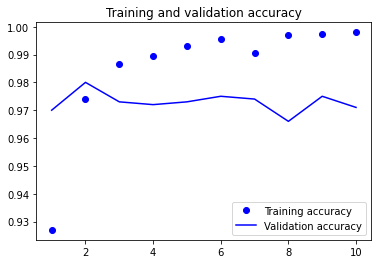

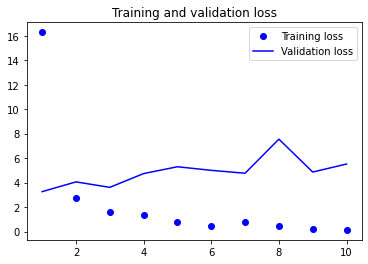

In [40]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation
Instantiating and freezing the VGG16 convolutional base

In [41]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing

In [42]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [43]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [44]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 1109s 18s/step - loss: 19.1000 - accuracy: 0.8920 - val_loss: 21.6222 - val_accuracy: 0.8990
Epoch 2/10
63/63 [==============================] - 1115s 18s/step - loss: 9.6530 - accuracy: 0.9275 - val_loss: 3.9328 - val_accuracy: 0.9730
Epoch 3/10
63/63 [==============================] - 1092s 17s/step - loss: 5.9773 - accuracy: 0.9565 - val_loss: 4.2349 - val_accuracy: 0.9760
Epoch 4/10
63/63 [==============================] - 1074s 17s/step - loss: 4.9972 - accuracy: 0.9605 - val_loss: 7.9708 - val_accuracy: 0.9620
Epoch 5/10
63/63 [==============================] - 1057s 17s/step - loss: 6.3481 - accuracy: 0.9535 - val_loss: 4.5300 - val_accuracy: 0.9810
Epoch 6/10
63/63 [==============================] - 1059s 17s/step - loss: 3.8209 - accuracy: 0.9690 - val_loss: 4.2127 - val_accuracy: 0.9760
Epoch 7/10
63/63 [==============================] - 1055s 17s/step - loss: 2.6353 - accuracy: 0.9745 - val_loss: 4.1755 - val_accuracy: 0.97

Evaluating the model on the test set


In [46]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 350s 11s/step - loss: 4.1277 - accuracy: 0.9740
Test accuracy: 0.974


Fine-tuning a pretrained model


In [47]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth from the last

In [48]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [49]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 1201s 19s/step - loss: 1.7324 - accuracy: 0.9815 - val_loss: 3.4027 - val_accuracy: 0.9780
Epoch 2/10
63/63 [==============================] - 1195s 19s/step - loss: 1.2473 - accuracy: 0.9800 - val_loss: 2.4141 - val_accuracy: 0.9830
Epoch 3/10
63/63 [==============================] - 1184s 19s/step - loss: 0.6659 - accuracy: 0.9860 - val_loss: 2.8469 - val_accuracy: 0.9720
Epoch 4/10
63/63 [==============================] - 1169s 19s/step - loss: 0.9337 - accuracy: 0.9870 - val_loss: 2.2010 - val_accuracy: 0.9810
Epoch 5/10
63/63 [==============================] - 1165s 19s/step - loss: 0.5146 - accuracy: 0.9865 - val_loss: 2.1941 - val_accuracy: 0.9830
Epoch 6/10
63/63 [==============================] - 1162s 18s/step - loss: 0.5919 - accuracy: 0.9885 - val_loss: 2.1550 - val_accuracy: 0.9800
Epoch 7/10
63/63 [==============================] - 1154s 18s/step - loss: 0.4414 - accuracy: 0.9890 - val_loss: 1.9767 - val_accuracy: 0.9820

In [50]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 345s 11s/step - loss: 2.3082 - accuracy: 0.9700
Test accuracy: 0.970


**Summary**
When we used a a pre-trained model with fine tuning, the test accuracy went upto 97%,which was comparitavely higher than the other models.

It can be inferred that increasing the sample size increases the accuracy which can be seen in the above steps, which indicates that the sample size is related to the accuracy and it plays an important role.

The pretrained model performed quickly as we already had the weights for the model.